In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N, same_stim_trial

figpath = os.path.join(p,'code','overleaf','multitask-nets','v3_figs','transfer')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [7]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0

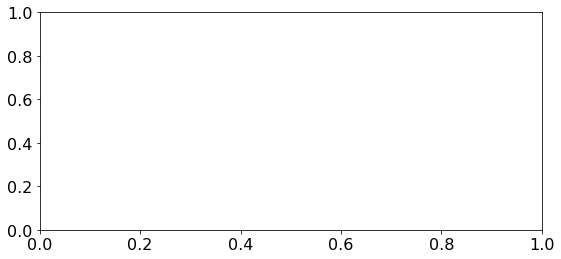

In [3]:
data_folder = 'data/rnn/multitask/'+net
data_folder = 'code/multitask-nets/'+net+'/data/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

# rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti','delayanti','reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo','dmsnogo','dmcgo', 'dmcnogo']
# # rule_trains_set['w_all_but_dmsnogo'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti','delayanti','reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_all_but_delayanti'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_key_motifs'] = ['delaygo', 'fdanti']
# rule_trains_set['wo_key_motifs'] = ['reactgo', 'dmcgo']
# rule_trains_set['wo_all_motifs'] = []


rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
# rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
# rule_trains_set['wo_all_motifs'] = []

post_train = 'delayanti'

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed) #'post_train_'+post_train
    
    m = os.path.join(p,transfer_m)
    
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    ax = plt.subplot(111)
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in rule_trains_set['w_all_motifs']:#hparams['rule_trains']:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*16)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            plt.plot(np.where(trial.x[0,0,5:]), np.mean(perf),'o',label = rule)
#             plt.text(np.where(trial.x[0,0,5:]), np.mean(perf),rule,rotation = 45)
            
    plt.title(rule_trains_label)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('tasks')
    plt.ylabel('performance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
      
    plt.show()

In [8]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'

In [9]:
model = Model(m)
model.hp

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model_params.npz'

In [15]:
from tools_lnd import get_model_params

In [16]:
w_in, b_in, w_out, b_out  = get_model_params(m)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_dmsgo:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/randgauss/leave_one_out/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsnogo_dmcgo_dmcnogo/post_train_dmsgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/randgauss/leave_one_out/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsnogo_dmcgo_dmcnogo/post_train_dmsgo/0/model.ckpt


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [10,256] rhs shape= [5,256]
	 [[Node: save_1/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@rnn/leaky_rnn_cell/kernel_input_stim"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/leaky_rnn_cell/kernel_input_stim, save_1/RestoreV2:18)]]

Caused by op u'save_1/Assign_18', defined at:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-2ab4281c9bf1>", line 1, in <module>
    w_in, b_in, w_out, b_out  = get_model_params(m)
  File "/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/tools_lnd.py", line 151, in get_model_params
    model.restore()
  File "/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/network.py", line 857, in restore
    self.saver = tf.train.Saver(self.var_list)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 112, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [10,256] rhs shape= [5,256]
	 [[Node: save_1/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@rnn/leaky_rnn_cell/kernel_input_stim"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/leaky_rnn_cell/kernel_input_stim, save_1/RestoreV2:18)]]


In [5]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[:22]
    b_in = params[22]
    w_out = params[23]
    b_out = params[24]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[24][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[23].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(np.concatenate(params[:22]).T,xh)+params[22]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 256) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/randgauss/leave_one_out/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_fdgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/lr/LeakyRNN/softplus/randgauss/leave_one_out/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_fdgo/0/model.ckpt


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [10,256] rhs shape= [5,256]
	 [[Node: save_1/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@rnn/leaky_rnn_cell/kernel_input_stim"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/leaky_rnn_cell/kernel_input_stim, save_1/RestoreV2:18)]]

Caused by op u'save_1/Assign_18', defined at:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-38f6ea9647c4>", line 3, in <module>
    model.restore()
  File "/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/network.py", line 857, in restore
    self.saver = tf.train.Saver(self.var_list)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 112, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [10,256] rhs shape= [5,256]
	 [[Node: save_1/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@rnn/leaky_rnn_cell/kernel_input_stim"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/leaky_rnn_cell/kernel_input_stim, save_1/RestoreV2:18)]]


ValueError: Axes instance argument was not found in a figure.

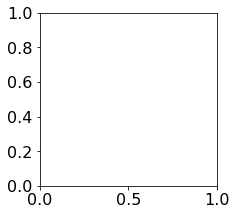

In [10]:
data_folder = 'code/multitask-nets/'+net+'/data/'
data_folder = 'data/rnn/multitask/transfer_learn/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = plt.subplot(1,2,1)
ax_perf = plt.subplot(2,2,1)

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_post = json.load(f)
    for r in range(len(task_list)):
        
        plt.sca(ax_cost)
        x = np.log(log_post['cost_'+task_list[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('Training Step (x 1000)')
        ax_cost.set_ylabel('Log Cost [MemoryAnti]')
        plt.xlim([-10,130]) 
#         plt.ylim([-3.2,3]) 
        
        plt.sca(ax_perf)
        x = log_post['perf_'+task_list[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_perf.set_xlabel('Training Step (x 1000)')
        ax_perf.set_ylabel('Performance [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-.05,1]) 
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1.1, 0.18))

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)

figname = 'cost_perf_transfer'
plt.savefig(os.path.join(figpath,figname+'.pdf'))
plt.savefig(os.path.join(figpath,figname+'.png'))


In [7]:
figpath

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v3_figs/transfer'

In [8]:
hparams

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'delay_fac': 1,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': -0.0,
 u'l1_weight': -0.0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.00031622776601683794,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 25,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 20,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7fae6dc73dc0>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [1.0],
 u'rule_start': 5,
 u'rule_trains': [u'delayanti'],
 u'rules': [u'delayanti'],
 u'ruleset': u'all',
 u'save_name': u'test',
 u'seed': 0,
 u'sigma_rec': 0.05,
 u'sigma_x': 0.1,
 u'target_cost': 0,
 u'target_perf': 1.0,
 u'tau': 100,
 u'use_separate_input': False,
 u'w_rec_init': u'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/25

In [15]:
f

<closed file '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delayanti/0/log.json', mode 'r' at 0x7faee912a270>

AttributeError: 'list' object has no attribute 'startswith'

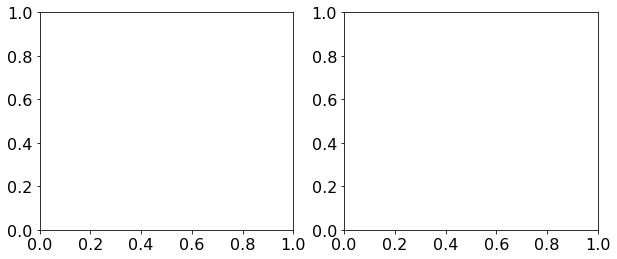

In [5]:
fig = plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = plt.subplot(121)
ax_perf = plt.subplot(122)

data_folder = os.path.join('data/rnn/multitask/','stepnet','lr')
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+'delayanti'

rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_label = rule_trains_set.keys()
s = '_'
rule_trains_str = s.join(rule_trains)
transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
m = os.path.join(p,transfer_m)
fname = os.path.join(m, 'log.json')
with open(fname, 'r') as f:
    log_post = json.load(f)
    
pretrain_m = os.path.join(data_folder,rnn_type,activation,init,'1_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
m = os.path.join(p,pretrain_m)
fname = os.path.join(m, 'log.json')
with open(fname, 'r') as f:
    log_pre = json.load(f)
for r in range(len(task_list)):

    plt.sca(ax_cost)
    x = np.log(log_pre['cost_'+task_list[r]])
    plt.plot(log_pre['trials'],x,'-',alpha = .5,linewidth = 4,label = 'Step 1')
    
    x = np.log(log_post['cost_'+task_list[r]])
    plt.plot(log_post['trials'],x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
    
#     ax_cost.set_xlabel('Training Step (x 10000)')
    ax_cost.set_ylabel('Log Cost '+ task_list[r])
    ax_cost.spines['top'].set_visible(False)
    ax_cost.spines['right'].set_visible(False)
    plt.xlim([-1000000,.2e8]) 
#         plt.ylim([-3.2,3]) 

    plt.sca(ax_perf)
    x = log_pre['perf_'+task_list[r]]
    plt.plot(log_pre['trials'],x,'-',alpha = .5,linewidth = 4,label = 'Step 1')
    ax_perf.spines['top'].set_visible(False)
    ax_perf.spines['right'].set_visible(False)
    
    
    x = log_post['perf_'+'delayanti']
    plt.plot(log_post['trials'],x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
    ax_perf.set_xlabel('Training Step')
    ax_perf.set_ylabel('Performance ' + task_list[r])
    plt.legend(bbox_to_anchor=(1.1, 0.18))
    plt.xlim([-1000000,.2e8]) 
#         plt.ylim([-.05,1]) 

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def gen_trial_set(ri_set):
    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

def gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num):

    h_A = get_h_epoch(m,trial_set[ri_axs],epoch_list[ri_axs],trial_num[ri_axs])
    h_end = h_A[:,-1] - h_A[:,0]
    h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch_list[1-ri_axs],trial_num[1-ri_axs])
    h_diff = h_B[:,-1] - h_A[:,-1]

    D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
    D_fp_qr,_ = LA.qr(D_fp)
    
    return D_fp_qr

def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

def get_h_epoch(m,trial,epoch,t_num):
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = x[:,t_num,T_inds]
    return h_epoch

def find_closest_fp_loc(h_end,x_star):

    closest_fp = np.argmin([LA.norm(h_end - x_star[fp,:]) for fp in range(len(x_star))])
    closest_fp_loc = x_star[closest_fp,:]
        
    return closest_fp, closest_fp_loc

def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                        q_thresh = 1e-3,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1,ellipse_foci = 0):

    fig_width = 5
    fig_height = 6
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    if epoch_list[0]=='stim1':
        step_file = 'interp_tasks_small_init_stim_transfer'
    else:
        step_file = 'interp_tasks_small_init_mov_transfer'
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    epoch_ax = epoch_list[ri_axs]
    rule_ax = rules_dict['all'][ri_set[ri_axs]]
    trial = gen_trials_from_model_dir(m,rule_ax,mode='test',noise_on = False)
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule_ax)
    f = get_single_task_fp_filename(trial,epoch_ax,trial_num[ri_axs])
    filename = os.path.join(save_dir,f+'.npz')
    D_use = make_FP_axs(filename, m, rule_ax, epoch_ax, axs = axs, clust = 'False')

    _, rule_name1, _, _ = take_names(epoch_list[0],rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict['all'][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0]
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rules_dict['all'][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

        for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
            ti = big_stim_trials[ti_ind]

            trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

            h0 = h_epoch[ti,0,:]
            x_t = trial.x[:T_inds[-1],ti,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            jitter = np.dot(h_t,D_use)
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:])

    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau'])

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 3, alpha = .5,linestyle = '-',c = c)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1, alpha = al,linestyle = '-',c = 'k')
        ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                       s = 20,c = 'k',marker = '^')
        ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                       s = 20,c = 'k',marker = 'x')

        dst_range = np.mean([LA.norm(h_t[t,:] - fp_struct['xstar'][fp_inds,:],axis = 1) 
                             for t in range(len(h_t))],axis = 0)

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
            CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
            CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
            if CA+CB >0:#< ellipse_foci*AB:
            
                dst_scale = 60
                al = .3
                
                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    facecolors='w'
                    edgecolors = c
                else:
                    facecolors=c
                    edgecolors = 'w'

                ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                              s = dst_scale, edgecolors = edgecolors, facecolors = facecolors, alpha = .5)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
    ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
    ax_fps.view_init(0, 0) #(-158, -125)
    plt.title('_'.join(epoch_list))

    tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
    step_file_name = step_file+'_foci_'+str(ellipse_foci)
    figpath = os.path.join(m,step_file_name,tasks_str,'_'.join(epoch_list))
    if not os.path.exists(figpath):
        os.makedirs(figpath)

    figname = 'interp_fps'+'_'+tasks_str
    plt.savefig(os.path.join(figpath,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,figname+'.png'))
    return ax_fps

In [18]:
import imageio
def interp_h_tasks_w_context_mov(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                        q_thresh = 1e-3,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1,ellipse_foci = 0):

    fig_width = 5
    fig_height = 6
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    if epoch_list[0]=='stim1':
        step_file = 'interp_tasks_small_init_stim_transfer'
    else:
        step_file = 'interp_tasks_small_init_mov_transfer'
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    epoch_ax = epoch_list[ri_axs]
    rule_ax = rules_dict['all'][ri_set[ri_axs]]
    trial = gen_trials_from_model_dir(m,rule_ax,mode='test',noise_on = False)
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule_ax)
    f = get_single_task_fp_filename(trial,epoch_ax,trial_num[ri_axs])
    filename = os.path.join(save_dir,f+'.npz')
    D_use = make_FP_axs(filename, m, rule_ax, epoch_ax, axs = axs, clust = 'False')

    _, rule_name1, _, _ = take_names(epoch_list[0],rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict['all'][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0]
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rules_dict['all'][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

        for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
            ti = big_stim_trials[ti_ind]

            trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

            h0 = h_epoch[ti,0,:]
            x_t = trial.x[:T_inds[-1],ti,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            jitter = np.dot(h_t,D_use)
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:])

    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau'])

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 3, alpha = .5,linestyle = '-',c = c)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1, alpha = al,linestyle = '-',c = 'k')
        ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                       s = 20,c = 'k',marker = '^')
        ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                       s = 20,c = 'k',marker = 'x')

        dst_range = np.mean([LA.norm(h_t[t,:] - fp_struct['xstar'][fp_inds,:],axis = 1) 
                             for t in range(len(h_t))],axis = 0)

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
            CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
            CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
            if CA+CB >0:#< ellipse_foci*AB:
            
                
                al = .3
                
                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    facecolors='w'
                    edgecolors = c
                    dst_scale = 60
                else:
                    facecolors=c
                    edgecolors = 'w'
                    dst_scale = 80

                ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                              s = dst_scale, edgecolors = edgecolors, facecolors = facecolors, alpha = .5)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
#     ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
#     ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
#     ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
    
    tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
    step_file_name = step_file+'_foci_'+str(ellipse_foci)
    figpath = os.path.join(m,step_file_name,tasks_str,'_'.join(epoch_list),'mov_no_axes')
    if not os.path.exists(figpath):
        os.makedirs(figpath)
        
    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.spines['bottom'].set_visible(False)
    ax_fps.spines['left'].set_visible(False)
    ax_fps.set_yticks([])
    ax_fps.set_xticks([])
    ax_fps.set_zticks([])
    
    for rot in range(0,360,3):
        ax_fps.view_init(0, rot) #(-158, -125)
        figname = 'interp_fps3D_rot'+'_'+tasks_str
        plt.savefig(os.path.join(figpath,figname+str(rot)+'.png'))

    images = []
    for mov_i in range(0,360,3):
        filename = os.path.join(figpath,figname+str(mov_i)+'.png')
        images.append(imageio.imread(filename))

    imageio.mimsave(os.path.join(figpath,'mov.gif'), images)

    return ax_fps

In [56]:
figpath = '/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/interp_tasks_small_init_stim_transfer_foci_0/fdanti_delayanti/stim1_stim1/mov_no_axes/'
figname = 'interp_fps3D_rot_fdanti_delayanti'
images = []
for mov_i in range(0,360,6):
    filename = os.path.join(figpath,figname+str(mov_i)+'.png')
    images.append(imageio.imread(filename))

imageio.mimsave(os.path.join(figpath,'mov.gif'), images)

In [8]:
def plot_task_overlap(m,ri_set,epoch_set = ['stim1','stim1'],tit = [],ri_axs = 1, plot_legend = False):
    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 14})

    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    axs = 'pca_h'
    rule_str = '_'.join(str(r) for r in rule_set)

    cmap_grad = plt.get_cmap('plasma')
    if ri_axs==1:
        cmap_discrete = ['dimgray','gainsboro']
    else:
        cmap_discrete = ['gainsboro','dimgray']
        

    epoch = epoch_set[ri_axs]
    rule = rule_set[ri_axs]

    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename,_ = get_filename(trial,epoch,0)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
    epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
    epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,(T_inds[0]-1):T_inds[-1]],(1,2,0))

        ax = plt.subplot(111)

        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 12,linestyle = '-', alpha = .1, markersize = 20)
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 4, 
               linestyle =  '-', alpha = .9, markersize = 10)

    if len(tit)<1:
        tit = rule_name1+' vs.'+rule_name2
    plt.title(tit,fontsize = 16,fontweight='bold')

    make_lil_axes(ax,['PC1','PC2'])

    fig_fldr = '2_task_viz'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.png'))
    plt.show()

    var_ex_X_task(m, rule_set[ri_axs], rule_set[1-ri_axs], [epoch_set[1-ri_axs],
                                                                epoch_set[ri_axs]], plot_legend = plot_legend)
    fig_fldr = '2_task_var'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.png'))
    plt.show()

In [9]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

def make_FP_axs(f,m_all,rule_in,fp_epoch,n_fps = 5,axs ='pca_fp', clust = 'False',n_components = 3):
        
    if axs == 'tdr':
        D_use = make_axes(m_all,rule_in,fp_epoch)
    elif axs =='pca_fp':

        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']

        if (clust == 'True') & (len(sorted_fps)>2):
            kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
            _,fp_inds = np.unique(kmeans.labels_,return_index=True)
        
        else:
            fp_inds = range(len(sorted_fps))

        pca = PCA(n_components = n_components)
        fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
        D_use = pca.components_.T
    elif axs =='pca_h':
        trial = gen_trials_from_model_dir(m_all,rule_in,mode='random',noise_on = False)
        X, _ = gen_X_from_model_dir_epoch(m_all,trial,fp_epoch)
        pca = PCA(n_components = n_components)
        fp_pca = pca.fit_transform(X.T)
        D_use = pca.components_.T
    elif axs =='out':
        w_in, b_in, w_out, b_out = get_model_params(m_all)
        D_use = w_out[:,1:]

    return D_use

def gen_X_from_model_dir_epoch(model_dir,trial,epoch,d = []):
    model = FixedPoint_Model(model_dir)
    with tf.Session() as sess:

        if len(d)==0:
            model.restore()
        else:
            model.saver.restore(sess,d)

        model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial       
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
        if trial.epochs[epoch][1] is None:
            epoch_range = range(trial.epochs[epoch][0],np.shape(h_tf)[0])
        elif trial.epochs[epoch][0] is None:
            epoch_range = range(0,trial.epochs[epoch][1])
        else:
            epoch_range = range(trial.epochs[epoch][0],trial.epochs[epoch][1])

        x = np.transpose(h_tf[epoch_range,:,:],(2,1,0)) #h_tf[:,range(1,n_trials),:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, x    #return hidden unit activity

def take_names(epoch,rule,epoch_axes = [],h_epoch = []):
    epochs = ['fix1','stim1','delay1','stim2','delay2','go1']
    epoch_names = ['context','stimulus','memory','stimulus','memory','response']

    print(epoch)

    ei = [i for i,e in enumerate(epochs) if e==epoch]
    epoch_name = epoch_names[ei[0]]
    
    rules = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

    rule_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SamplePro', 'DelayMatch2SampleAnti', 'DelayMatch2CategoryPro', 'DelayMatch2CategoryAnti']

    ri = [i for i,e in enumerate(rules) if e==rule]
    rule_name = rule_names[ri[0]]
    
    if len(epoch_axes)<1:
        epoch_axes_name = epoch_names[ei[0]]
    else:
        ei = [i for i,e in enumerate(epochs) if e==epoch_axes]
        epoch_axes_name = epoch_names[ei[0]]
    
    if len(h_epoch)==0:
        h_epoch = epoch
    
    return epoch_name, rule_name, epoch_axes_name, h_epoch

def make_lil_axes(ax,axes_labels,fontsize = 14):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    [x1,x2] = ax.get_xlim()
    x1 = x1*.8
    x2 = x2*.8
    x_diff = x2-x1
    [y1,y2] = ax.get_ylim()
    y1 = y1*.8
    y2 = y2*.8
    y_diff = y2-y1

    plt.plot([x1,x1+x_diff/10],[y1,y1],'-k')
    plt.plot([x1,x1],[y1,y1+y_diff/10],'-k')
    plt.text(x1,y1-y_diff/10,axes_labels[0],fontsize = fontsize)
    plt.text(x1-x_diff/8,y1+y_diff/20,axes_labels[1],fontsize = fontsize)
    ax.set_yticks([])
    ax.set_xticks([])

In [10]:
def var_ex_X_task(m, rule_ax, rule, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    _, rule_name, _, _ = take_names(epoch_set[0],rule)
    _, rule_name_ax, _, _ = take_names(epoch_set[1],rule_ax)

    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = batch_size)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_ax,mode='random',noise_on = False,batch_size = batch_size)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)
    plt.rcParams.update({'font.size': 14})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .2,
             label = 'Same Task PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .2,label = 'Other Task PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-10,500])
    if plot_legend==True:
        plt.legend()

In [11]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [12]:
def comp_eig_decomp(Ms, sort_by='real',do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt


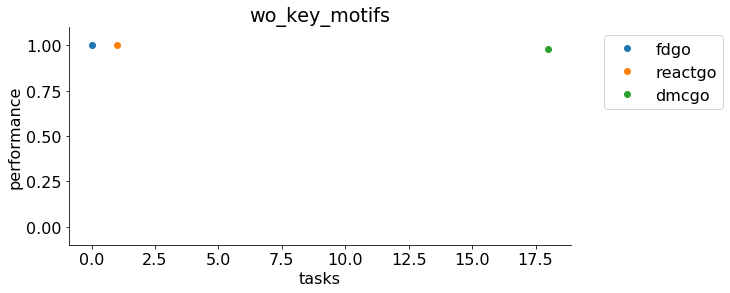

In [20]:
data_folder = 'data/rnn/multitask/'+net
data_folder = 'code/multitask-nets/'+net+'/data/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

# rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti','delayanti','reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo','dmsnogo','dmcgo', 'dmcnogo']
# # rule_trains_set['w_all_but_dmsnogo'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti','delayanti','reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_all_but_delayanti'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_key_motifs'] = ['delaygo', 'fdanti']
# rule_trains_set['wo_key_motifs'] = ['reactgo', 'dmcgo']
# rule_trains_set['wo_all_motifs'] = []


rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
# rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
# rule_trains_set['wo_all_motifs'] = []

post_train = 'delayanti'

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed) #'post_train_'+post_train
    
    m = os.path.join(p,transfer_m)
    
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    ax = plt.subplot(111)
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in rule_trains_set[rule_trains_label]:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*16)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            plt.plot(np.where(trial.x[0,0,5:]), np.mean(perf),'o',label = rule)
#             plt.text(np.where(trial.x[0,0,5:]), np.mean(perf),rule,rotation = 45)
            
    plt.title(rule_trains_label)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('tasks')
    plt.ylabel('performance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
      
    plt.show()

In [35]:
%matplotlib

Using matplotlib backend: MacOSX


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask

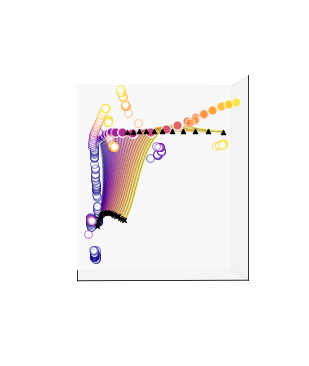

In [21]:
ri_set = [0,5]
epoch_set = ['stim1','stim1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Anti Stim Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context_mov(ri_set,trial_num,epoch_set,ri_axs = 0)
plt.show()

In [73]:
ri_set = [18,5]
epoch_set = ['go1','go1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Delay Prep Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,ri_axs = 0)
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask

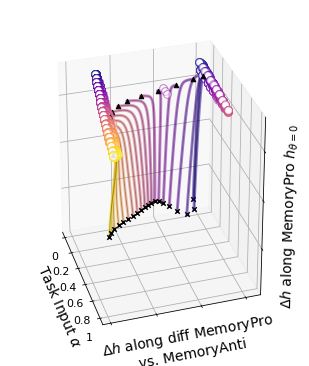

In [43]:
ri_set = [2,5]
epoch_set = ['delay1','delay1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Delay Prep Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,ri_axs = 0)
plt.show()

In [77]:
ri_set = [3,5]
epoch_set = ['go1','go1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Delay Prep Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,ri_axs = 0)
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/c

Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


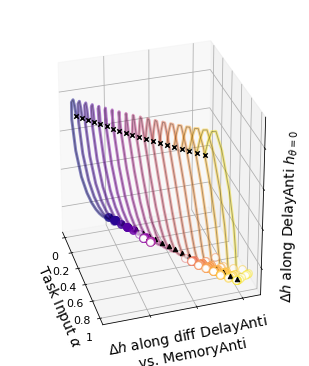

In [18]:
ri_set = [3,5]
epoch_set = ['go1','go1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Delay Prep Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,ri_axs = 0)
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/c

Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


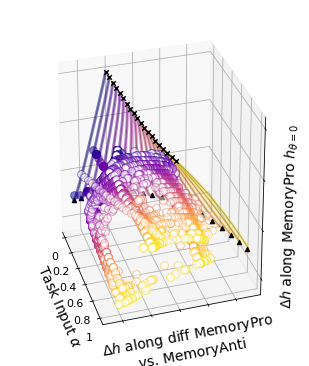

In [27]:
 ri_set = [2,5]
epoch_set = ['stim1','stim1']
trial_num = [0,0]

# plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Delay Prep Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,ri_axs = 0,ellipse_foci = 100)
plt.show()

In [11]:
for x in range(len(rule_trains)+1):
    rule_trains_temp = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
    rule_trains_temp.pop(x)
    print rule_trains_temp

0
['reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
1
['fdgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
2
['fdgo', 'reactgo', 'fdanti', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
3
['fdgo', 'reactgo', 'delaygo', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
4
['fdgo', 'reactgo', 'delaygo', 'fdanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
5
['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 

In [5]:
x

8